In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time

In [3]:
from dataprep.helperfunctions import *
from dataprep.memory_helperfunctions import prepare_data_f_memory

In [4]:
from simulation.simulation_pipeline import *
from simulation.simulation_helpers import *

In [5]:
import pomegranate

In [6]:
from experiment.DoE import *

# Make a design table

In [7]:
run_settings = {"process_entropy":["min_entropy","med_entropy","max_entropy"], #,"med_entropy","max_entropy","med_entropy","max_entropy"
                "number_of_traces":[100],
                "statespace_size":[5,10],
                "process_type":["memoryless","memory"],        #"memoryless","memory" 
                
                #order of HOMC
                "process_memory":[4],
                
                #number of transitions
                "med_ent_n_transitions":[3,5],
                                
                #lambda parameter of inter-arrival times
                "inter_arrival_time":[1.5],
                #lambda parameter of process noise
                "process_stability_scale":[0.1],
                
                #probability of getting an agent
                "resource_availability_p":[0.5],
                #number of agents
                "resource_availability_n":[3],
                #waiting time in days, when no agent is available
                "resource_availability_m":[0.041],
                
                #variation between activity durations
                "activity_duration_lambda_range":[1],
                #business hours definition: when can cases be processed?
                "Deterministic_offset_W":["weekdays"], #weekdays, all-week
                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                "Deterministic_offset_u":[7],
                
                #run full model pipeline from simulated data
                "model_pipeline":[False],
                
                #repeat the experiment
                "num_replications":list(range(0,1))
               }


# Generate a full factorial:
df=build_full_fact(run_settings)#[0:2]

# Recode the string factor levels (recoding from natural number to string)
df = fix_label_values(df, run_settings, variables = ["process_entropy",
                                                     "process_type",
                                                     "Deterministic_offset_W",
                                                     "model_pipeline"])
df = df.drop("Name_fix",axis=1)
# Important variables
df["RUN"] = df.index + 1
df["Done"] = 0
df["Failure"] = 0

#change types and save
df.statespace_size = df.statespace_size.astype(int)
df.to_csv("results/design_table.csv",index=False)
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,resource_availability_m,activity_duration_lambda_range,Deterministic_offset_W,Deterministic_offset_u,model_pipeline,num_replications,RUN,Done,Failure
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,1,0,0
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,2,0,0
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,3,0,0
3,min_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,4,0,0
4,med_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,5,0,0
5,max_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,6,0,0
6,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,7,0,0
7,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,8,0,0
8,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,9,0,0
9,min_entropy,100.0,10,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,10,0,0


In [8]:
#df = df.loc[:1]
#df

# Perform the experiments

In [9]:
results = []

for run in df.index:
    print(run)
    
    start_time = time.time()
    
    """
    Settings from experiments
    """
    curr_settings = df.loc[run]
    
    """
    settings for the simulation
    """
    
    SIM_SETTINGS = {"save_eventlog":1, #0 = no, 1 = yes...
                
                "statespace_size":make_D(int(curr_settings["statespace_size"])),

                "number_of_traces":int(curr_settings["number_of_traces"]),  

                "process_entropy":curr_settings["process_entropy"],

                "process_type":curr_settings["process_type"],                

                "process_memory":int(curr_settings["process_memory"]),          
                    
                # desired max number of possible transitions in P. 
                # NOTE: This can maximally be the number of states, and should be higher than 2
                "med_ent_n_transitions":int(curr_settings["med_ent_n_transitions"]),
                    
                #lambda parameter of inter-arrival times
                "time_settings":{"inter_arrival_time":float(curr_settings["inter_arrival_time"]), 
                                 
                                #lambda parameter of process noise
                                "process_stability_scale":float(curr_settings["process_stability_scale"]),
                                 
                                #probability of getting an agent
                                "resource_availability_p":float(curr_settings["resource_availability_p"]),                          
                                #waiting time in days, when no agent is available      
                                "resource_availability_n":int(curr_settings["resource_availability_n"]),
                                #waiting time in days, when no agent is available
                                "resource_availability_m":float(curr_settings["resource_availability_m"]), 
                                 
                                #variation between activity durations
                                "activity_duration_lambda_range":float(curr_settings["activity_duration_lambda_range"]),

                                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                                "Deterministic_offset_W":make_workweek(curr_settings["Deterministic_offset_W"]),

                                "Deterministic_offset_u":int(curr_settings["Deterministic_offset_u"])},
                #offset for the timestamps
                "datetime_offset":365*53,
                #run is the seed
                "run":run}

    # generate the log
    log = Generate_eventlog(SIM_SETTINGS)
    #log.to_csv("results/"+str(run)+"log.csv",index=False)
    
    # log simulated log characteristics
    curr_settings["simuation_time_sec"] = time.time() - start_time
    curr_settings["num_traces"] = len(log.caseid.unique())
    curr_settings["num_events"] = len(log)
    
    variants = []
    tracelengths = []
    for traceid in log.caseid.unique():
        trace = log.loc[log.caseid == traceid]
        #tracelen
        tracelen = len(trace)
        tracelengths.append(tracelen)
        #variant
        sequence = ""
        sequence = sequence.join(trace.activity.tolist())
        variants.append(sequence)
        
    n_variants = len(set(variants))       
    
    curr_settings["num_variants"] = n_variants
    
    curr_settings["avg_tracelen"] = np.mean(tracelengths)
    curr_settings["min_tracelen"] = np.min(tracelengths)
    curr_settings["max_tracelen"] = np.max(tracelengths)
    
    

    # run a machine learning pipeline as well?
    if curr_settings["model_pipeline"] == True:
        """
        Prepare data for modelling
        """
        input_data = prepare_data_f_memory(log)

        """
        Train a model
        """
        # X: 
        input_data["x_train"]
        input_data["x_test"]

        # Y:
        input_data["y_test"]
        input_data["y_test"]

        """
        Evaluate the model
        """

    
        """
        Store the results
        """
        curr_settings["RES_num_events"] = len(log)
        
    #append
    #curr_settings = pd.DataFrame(curr_settings.T)
    #curr_settings.index = [run]
    results.append(curr_settings)
#store results
results = pd.DataFrame(results)
results.to_csv("results/experiments.csv",index=False)  

0
traces: 100
events: 500
ids: 100
1
traces: 100
events: 570
ids: 100
2
traces: 100
events: 581
ids: 100
3
traces: 100
events: 1000
ids: 100
4
traces: 100
events: 588
ids: 100
5
traces: 100
events: 1078
ids: 100
6
traces: 100
events: 500
ids: 100
7
generated traces: 100
traces: 100
events: 665
ids: 100
8
generated traces: 100
traces: 100
events: 645
ids: 100
9
traces: 100
events: 1000
ids: 100
10
generated traces: 100
traces: 100
events: 599
ids: 100
11
generated traces: 100
traces: 100
events: 911
ids: 100
12
traces: 100
events: 500
ids: 100
13
traces: 100
events: 540
ids: 100
14
traces: 100
events: 579
ids: 100
15
traces: 100
events: 1000
ids: 100
16
traces: 100
events: 1182
ids: 100
17
traces: 100
events: 786
ids: 100
18
traces: 100
events: 500
ids: 100
19
generated traces: 100
traces: 100
events: 581
ids: 100
20
generated traces: 100
traces: 100
events: 609
ids: 100
21
traces: 100
events: 1000
ids: 100
22
generated traces: 100
traces: 100
events: 667
ids: 100
23
generated traces: 1

In [10]:
results

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,RUN,Done,Failure,simuation_time_sec,num_traces,num_events,num_variants,avg_tracelen,min_tracelen,max_tracelen
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,1,0,0,0.108273,100,500,1,5.00,5,5
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,2,0,0,0.112743,100,570,66,5.70,1,21
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,3,0,0,0.108276,100,581,83,5.81,1,24
3,min_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,4,0,0,0.159430,100,1000,1,10.00,10,10
4,med_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,5,0,0,0.111253,100,588,66,5.88,1,31
5,max_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,6,0,0,0.163899,100,1078,95,10.78,1,47
6,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,7,0,0,0.100824,100,500,1,5.00,5,5
7,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,8,0,0,4.346827,100,665,79,6.65,1,39
8,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,9,0,0,7.020879,100,645,83,6.45,1,37
9,min_entropy,100.0,10,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,10,0,0,0.346673,100,1000,1,10.00,10,10


In [11]:
#log.to_csv("log.csv",index=False)
log.head()

,caseid,activity,activity_no,y_acc_sum,n_t,u_t,z_t,h_t,b_t,q_t,s_t,v_t,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,e,1,2.647024,2.479114,2.647024,2.479114,0.082,0.158688,2.719802,0.000000,0.167910,2022-12-25 11:29:55,2022-12-25 17:16:30,2022-12-25 15:31:42,Sunday,17
1,0,j,2,5.338067,2.647024,2.691043,2.479114,0.041,0.065703,2.753727,0.000000,0.044019,2022-12-25 15:31:42,2022-12-25 18:05:21,2022-12-25 16:35:06,Sunday,18
2,0,j,3,8.765251,2.691043,3.427184,2.479114,0.082,0.287152,3.060195,0.439805,0.296336,2022-12-25 16:35:06,2022-12-26 12:00:00,2022-12-26 10:15:08,Monday,12
3,0,c,4,12.241488,3.427184,3.476237,2.479114,0.082,0.046630,3.555814,0.000000,0.049053,2022-12-26 10:15:08,2022-12-26 13:20:22,2022-12-26 11:25:46,Monday,13
4,0,b,5,15.731868,3.476237,3.490380,2.479114,0.000,0.024298,3.500536,0.000000,0.014143,2022-12-26 11:25:46,2022-12-26 12:00:46,2022-12-26 11:46:08,Monday,12


# Inspect example data

In [12]:
log

,caseid,activity,activity_no,y_acc_sum,n_t,u_t,z_t,h_t,b_t,q_t,s_t,v_t,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,e,1,2.647024,2.479114,2.647024,2.479114,0.082,0.158688,2.719802,0.000000,0.167910,2022-12-25 11:29:55,2022-12-25 17:16:30,2022-12-25 15:31:42,Sunday,17
1,0,j,2,5.338067,2.647024,2.691043,2.479114,0.041,0.065703,2.753727,0.000000,0.044019,2022-12-25 15:31:42,2022-12-25 18:05:21,2022-12-25 16:35:06,Sunday,18
2,0,j,3,8.765251,2.691043,3.427184,2.479114,0.082,0.287152,3.060195,0.439805,0.296336,2022-12-25 16:35:06,2022-12-26 12:00:00,2022-12-26 10:15:08,Monday,12
3,0,c,4,12.241488,3.427184,3.476237,2.479114,0.082,0.046630,3.555814,0.000000,0.049053,2022-12-26 10:15:08,2022-12-26 13:20:22,2022-12-26 11:25:46,Monday,13
4,0,b,5,15.731868,3.476237,3.490380,2.479114,0.000,0.024298,3.500536,0.000000,0.014143,2022-12-26 11:25:46,2022-12-26 12:00:46,2022-12-26 11:46:08,Monday,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,99,d,20,3134.523015,163.616144,163.902891,147.368439,0.082,0.043687,2.741832,0.000000,0.286746,2023-06-04 14:47:14,2022-12-25 17:48:14,2023-06-04 21:40:09,Sunday,17
958,99,e,21,3298.473111,163.902891,163.950096,147.368439,0.041,0.030237,2.974128,0.000000,0.047205,2023-06-04 21:40:09,2022-12-25 23:22:44,2023-06-04 22:48:08,Sunday,23
959,99,g,22,3463.528620,163.950096,165.055508,147.368439,0.082,0.269004,3.301100,0.198900,0.906512,2023-06-04 22:48:08,2022-12-26 12:00:00,2023-06-06 01:19:55,Monday,12
960,99,j,23,3629.169279,165.055508,165.640660,147.368439,0.082,0.091908,4.229416,0.270584,0.314568,2023-06-06 01:19:55,2022-12-27 12:00:00,2023-06-06 15:22:32,Tuesday,12


In [13]:
log['arrival_datetime'].describe()

count                     962
unique                    962
top       2022-12-25 11:29:55
freq                        1
first     2022-12-25 11:29:55
last      2023-06-06 15:22:32
Name: arrival_datetime, dtype: object

<AxesSubplot:xlabel='arrival_datetime'>

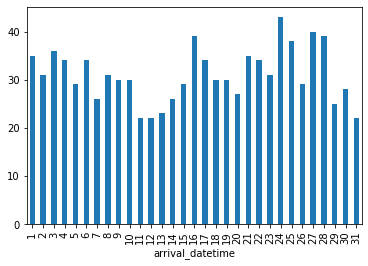

In [14]:
log['caseid'].groupby(log['arrival_datetime'].dt.day).count().plot(kind="bar")

<AxesSubplot:xlabel='arrival_datetime'>

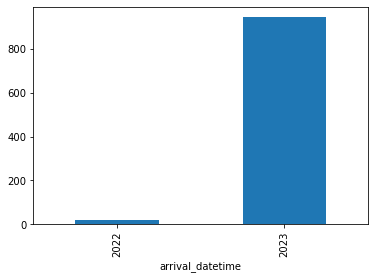

In [15]:
log['caseid'].groupby(log['arrival_datetime'].dt.year).count().plot(kind="bar") #dayofyear

In [16]:
#input_data

In [17]:
import pm4py

In [18]:
log.columns

Index(['caseid', 'activity', 'activity_no', 'y_acc_sum', 'n_t', 'u_t', 'z_t',
       'h_t', 'b_t', 'q_t', 's_t', 'v_t', 'arrival_datetime', 'start_datetime',
       'end_datetime', 'start_day', 'start_hour'],
      dtype='object')

In [19]:
log = log.rename(columns={"caseid":"case:concept:name",
                         "activity":"concept:name",
                         "start_datetime":"time:timestamp"})

dataframe = pm4py.format_dataframe(log[["case:concept:name","concept:name","time:timestamp"]], 
                                   case_id='case:concept:name', 
                                   activity_key='concept:name', 
                                   timestamp_key='time:timestamp',
                                   timest_format="yyyy-%mm-%dd %hh:%mm:%ss")

event_log = pm4py.convert_to_event_log(dataframe)
event_log

[{'attributes': {'concept:name': '0'}, 'events': [{'concept:name': 'e', 'time:timestamp': Timestamp('2022-12-25 17:16:30'), '@@index': 0}, '..', {'concept:name': 'j', 'time:timestamp': Timestamp('2022-12-26 13:28:12'), '@@index': 5}]}, '....', {'attributes': {'concept:name': '99'}, 'events': [{'concept:name': 'h', 'time:timestamp': Timestamp('2022-12-23 12:00:00'), '@@index': 938}, '..', {'concept:name': 'h', 'time:timestamp': Timestamp('2022-12-30 12:00:00'), '@@index': 961}]}]

In [20]:
# Petri net from inductive miner
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

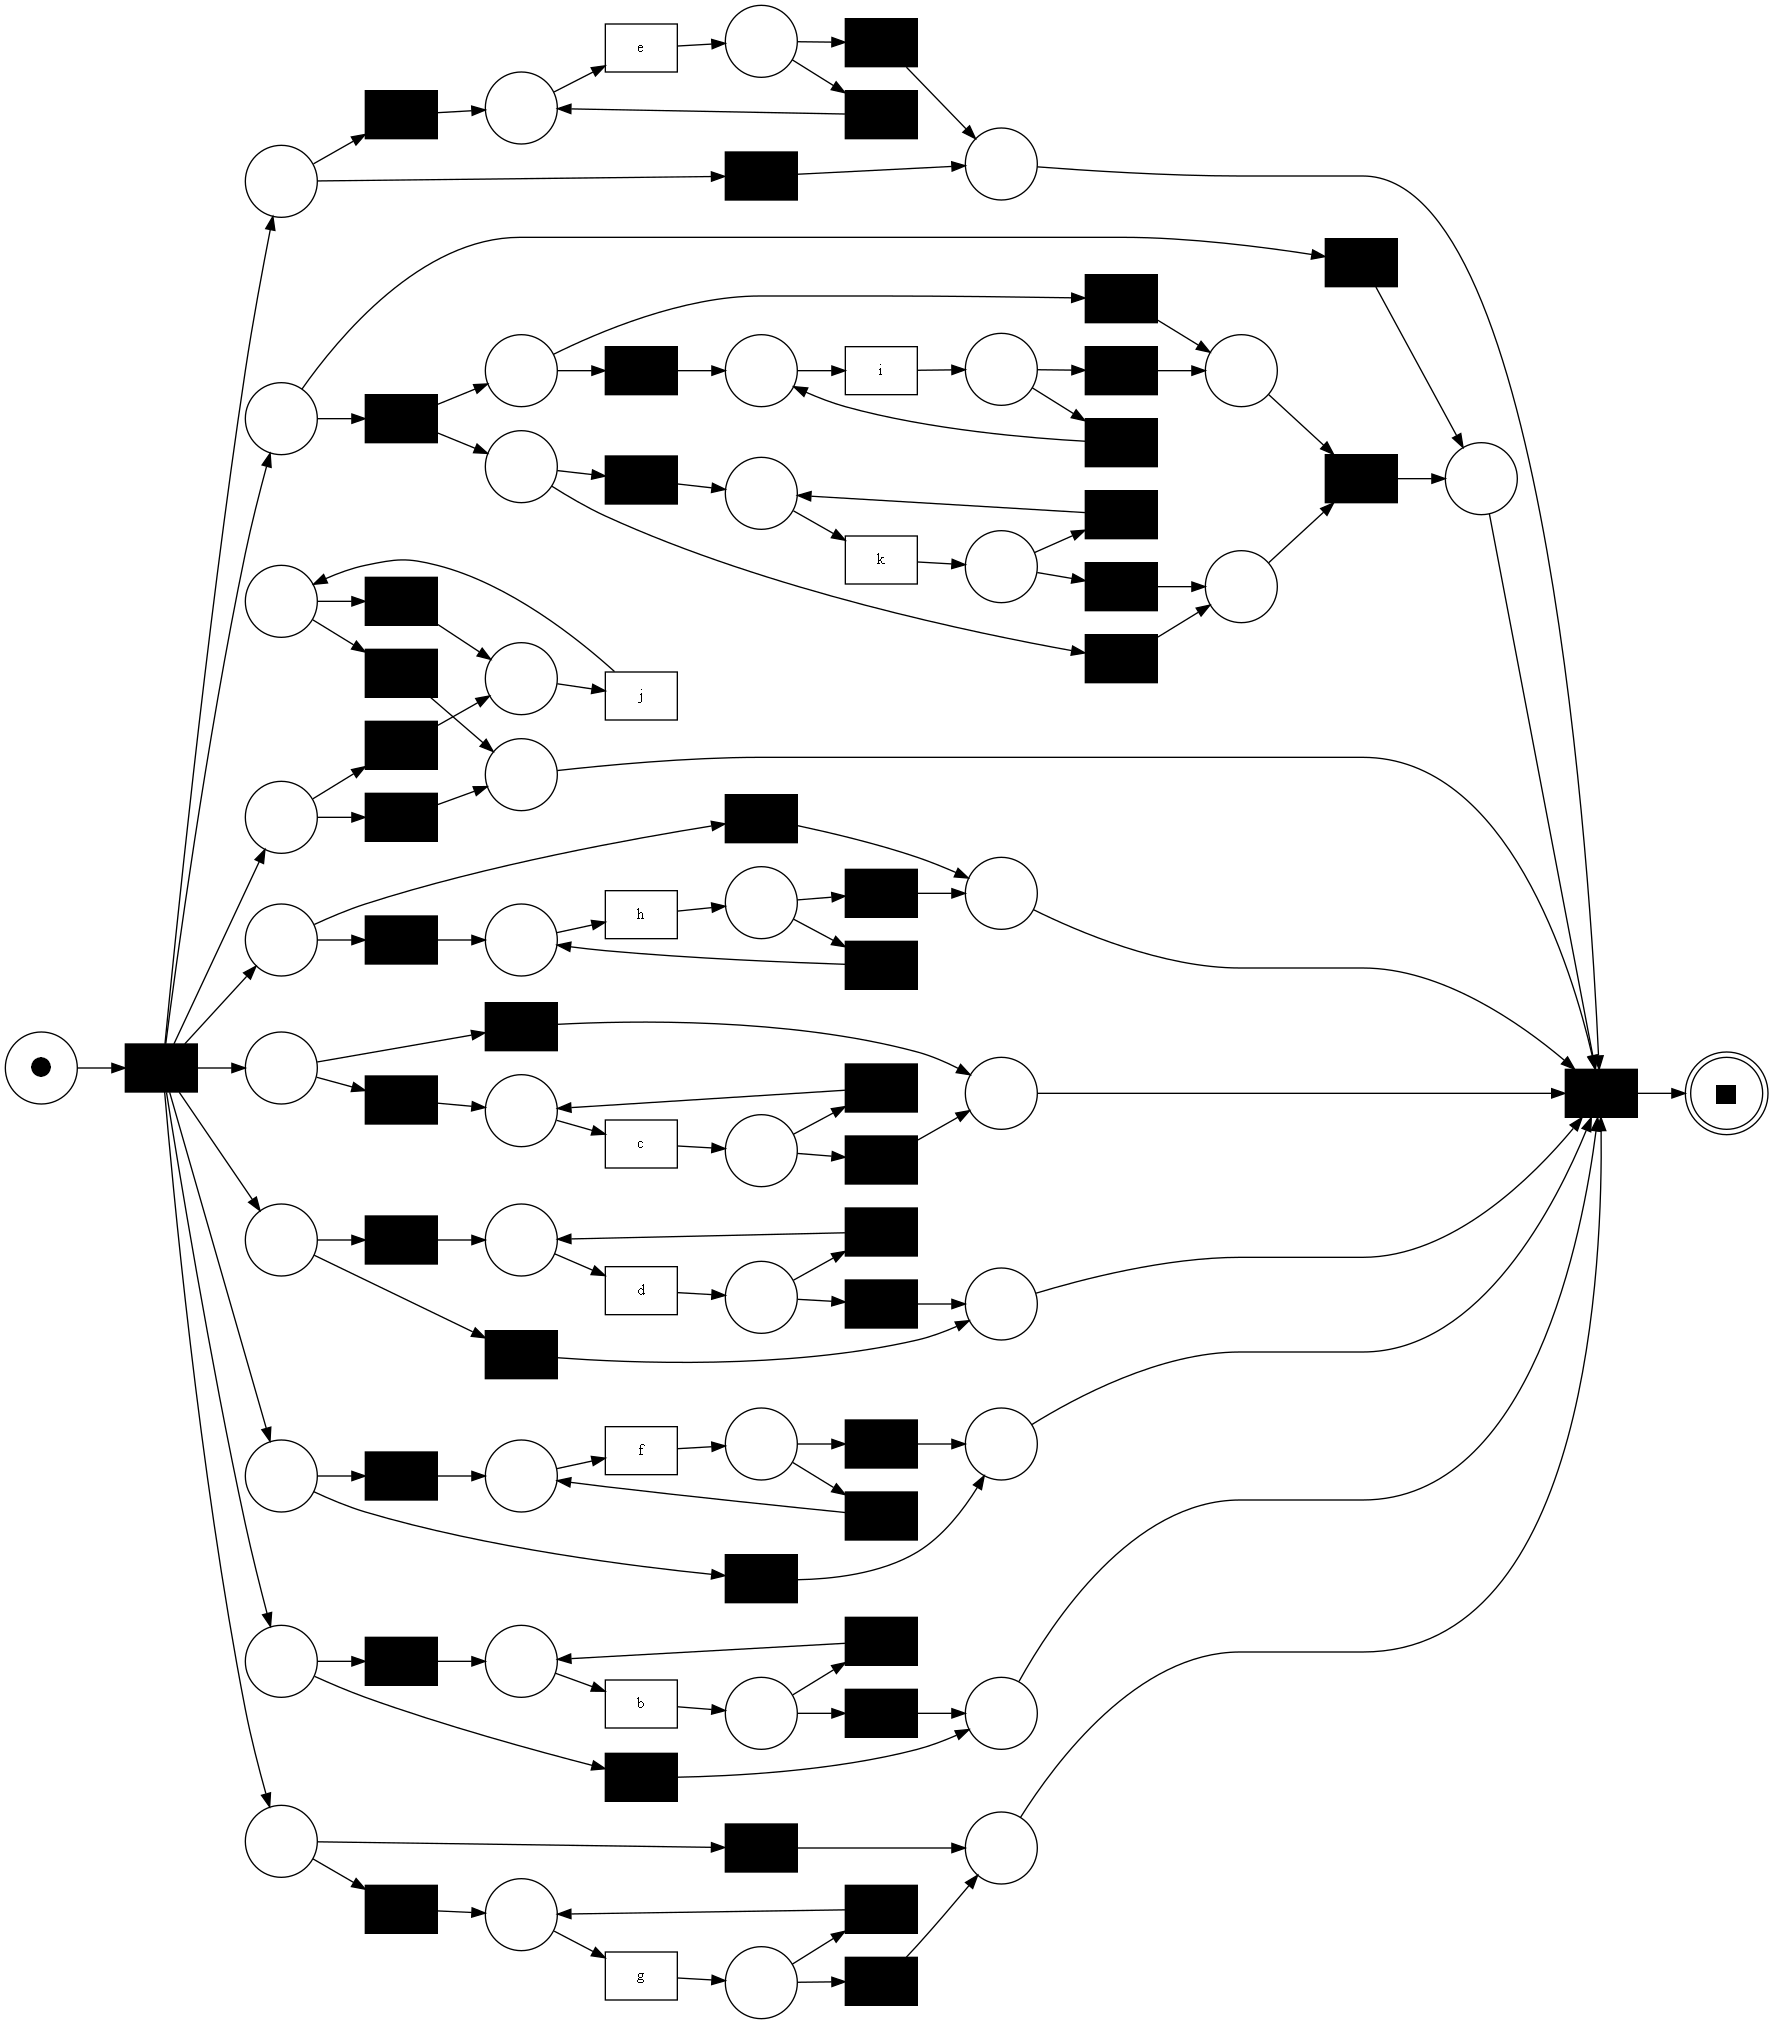

In [21]:
pm4py.view_petri_net(net, initial_marking, final_marking)

In [22]:
tree = pm4py.discover_process_tree_inductive(event_log)

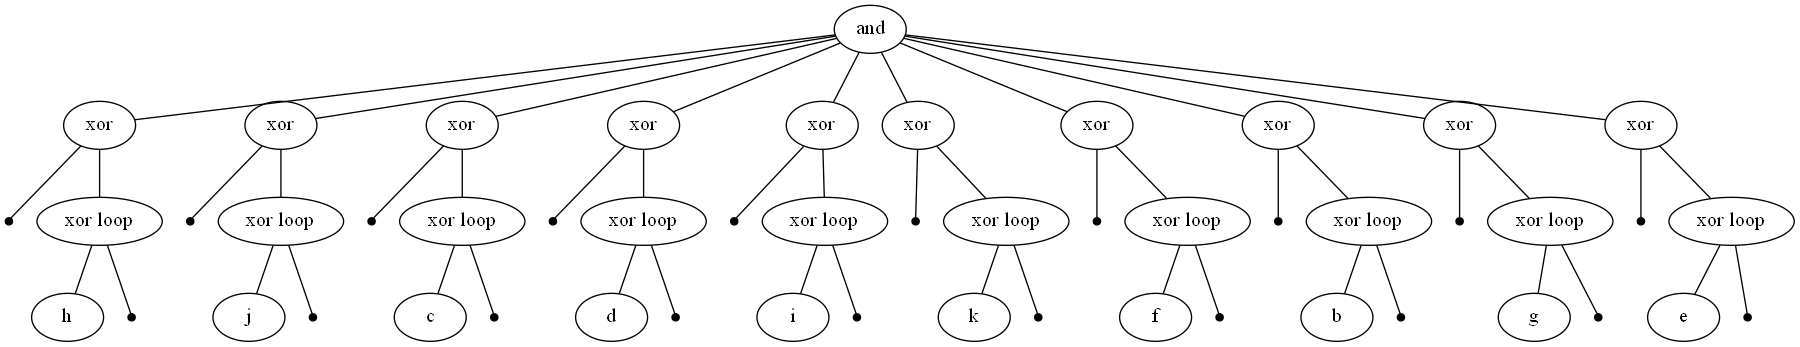

In [23]:
pm4py.view_process_tree(tree)

In [24]:
bpmn_graph = pm4py.convert_to_bpmn(tree)

In [25]:
#bpmn_graph = layouter.apply(bpmn_graph)

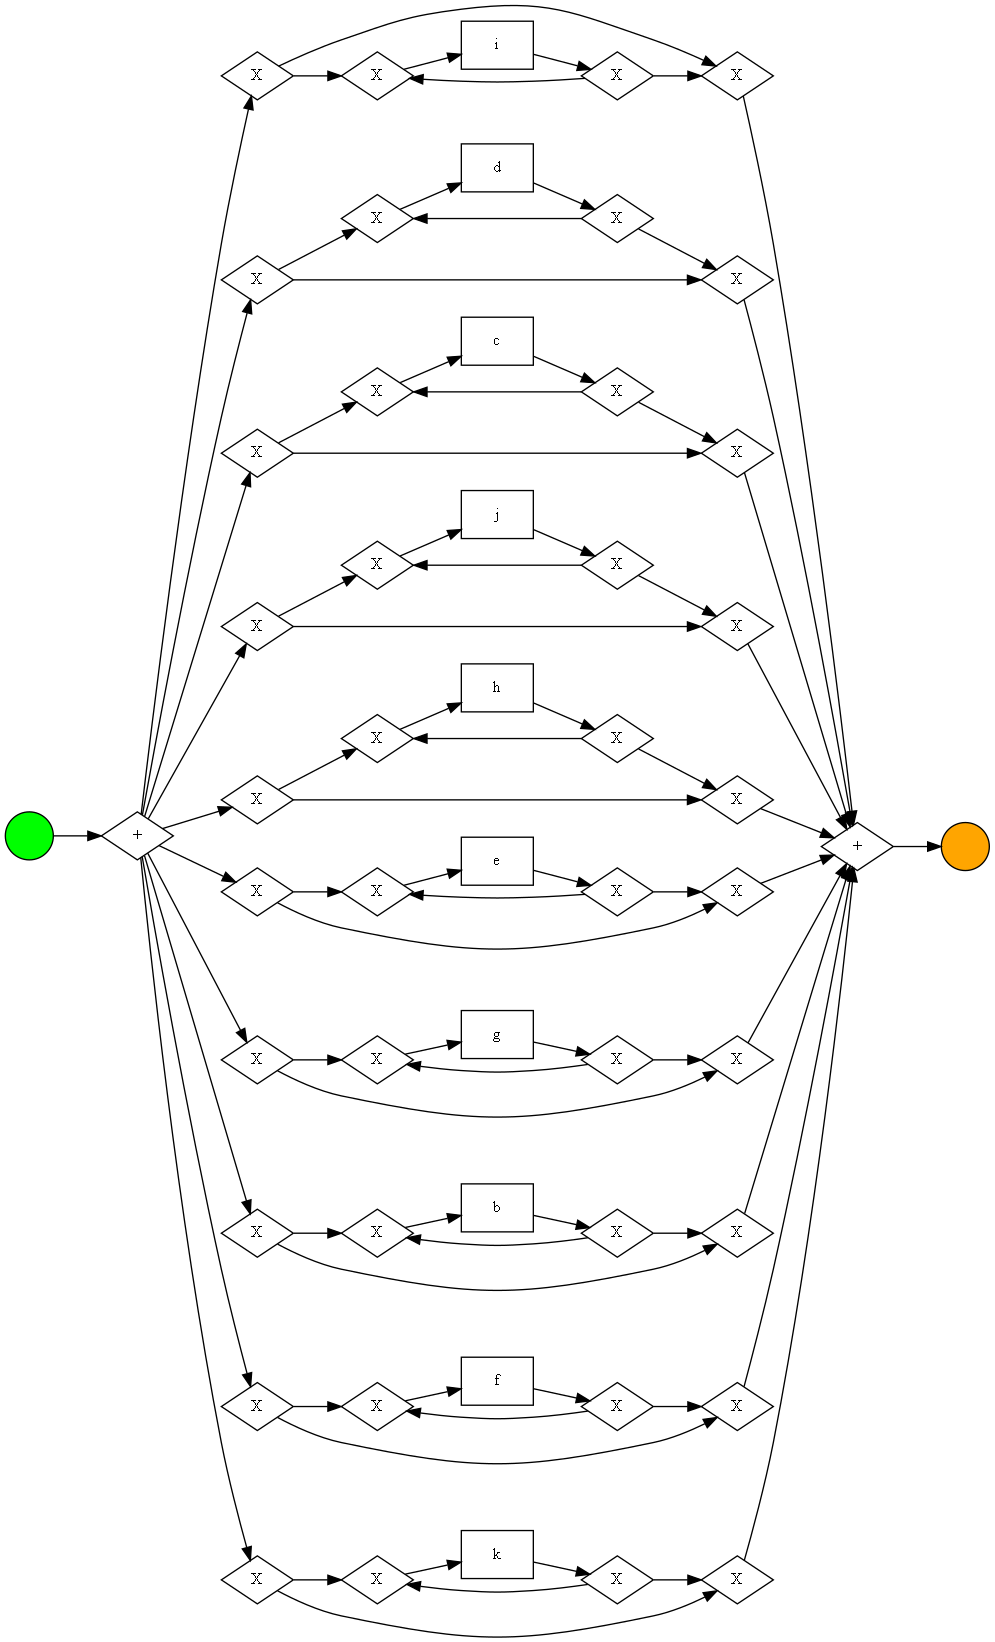

In [26]:
pm4py.view_bpmn(bpmn_graph)